<a href="https://colab.research.google.com/github/JoshuaOmondi/Data-Projects/blob/master/FPL_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Using Python to create the best Fantasy Premier League (FPL) Team**

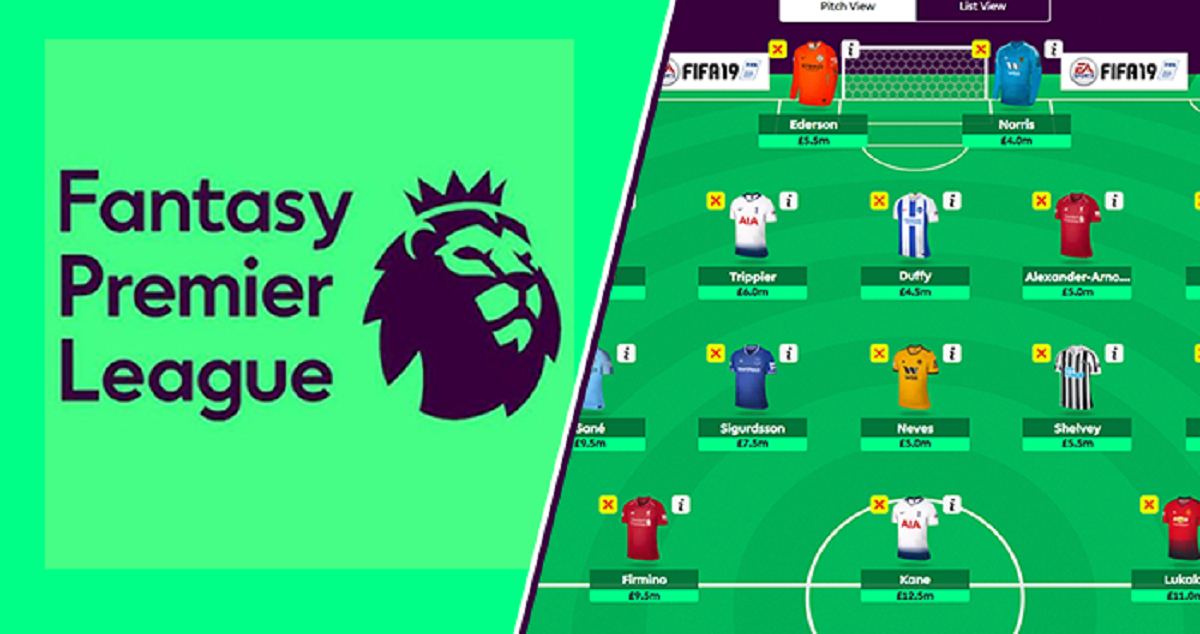

### **Introduction - What is Fantasy Premier League?**

FPL is a game that casts you in the role of a fantasy manager of premier league players. As a manger, you are required to create a team of 15 players. The players will score points for your team based on their actual performance in the league. Each player is given a price based on their projected performance and the budget is £100.0m for the 15-man squad. Your team scores points based on the performance of the starting XI members of the squad. As you can see, choosing a team that will give you maximum points can be quite a challenge. One's bias might affect which players one will want to buy. To eliminate personal bias in choosing the best team to play with, I use linear programming to create a function that maximizes my points given the constraints that I have, which are 15-man squad and a fixed budget of £100.0m.

These are the steps to be used.
* Describing the problem.( Building a team that gives maximum pts given the budget)
* Formulate the mathematical program
* Solving the mathematical program
* Evaluating the result
* Finalizing the result
Data required: player price, team, points and position.
Constraints: budget and number of players.

### **Data Collection**

The premier league has a lot of data spanning back several years. The data for this project was obtained through accessing the FPL API endpoints.

In [ ]:
pip install pulp

     |████████████████████████████████| 14.2 MB 5.3 MB/s 


In [ ]:
#importing libraries
import pandas as pd
from pulp import *

In [ ]:
! git clone https://github.com/vaastav/Fantasy-Premier-League.git

Cloning into 'Fantasy-Premier-League'...
remote: Enumerating objects: 182996, done.
remote: Counting objects: 100% (61922/61922), done.
remote: Compressing objects: 100% (28160/28160), done.
remote: Total 182996 (delta 32733), reused 56749 (delta 27746), pack-reused 121074
Receiving objects: 100% (182996/182996), 63.95 MiB | 9.90 MiB/s, done.
Resolving deltas: 100% (89775/89775), done.
Checking out files: 100% (8530/8530), done.


In [ ]:
#Loading data
PATH = 'Fantasy-Premier-League/data/'

current_df = pd.read_csv(PATH + '2021-22/gws/merged_gw.csv')
current_df.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Eric Bailly,DEF,Man Utd,0.0,0,0,0,0,0.0,286,6,0,0,0.0,0.0,2021-08-14T11:30:00Z,0,10,0,0,0,0,1,0,9363,1,5,0.0,0,0,0,0,50,True,0,1
1,Keinan Davis,FWD,Aston Villa,0.4,0,0,0,0,0.0,49,8,0,0,0.0,0.0,2021-08-14T14:00:00Z,0,18,0,0,0,0,1,0,169789,2,3,0.0,0,0,0,0,45,False,0,1
2,Ayotomiwa Dele-Bashiru,MID,Watford,0.0,0,0,0,0,0.0,394,8,0,0,0.0,0.0,2021-08-14T14:00:00Z,0,2,0,0,0,0,1,0,4092,2,3,0.0,0,0,0,0,45,True,0,1
3,James Ward-Prowse,MID,Southampton,2.3,0,0,20,0,30.5,341,4,3,0,5.2,21.6,2021-08-14T14:00:00Z,90,8,0,0,0,0,1,0,299682,1,3,0.0,2,0,0,0,65,False,0,1
4,Bruno Miguel Borges Fernandes,MID,Man Utd,4.4,0,3,61,0,35.9,277,6,1,3,20.1,106.2,2021-08-14T11:30:00Z,90,10,0,0,0,0,1,0,3381004,1,5,59.0,20,0,0,0,120,True,0,1


In [ ]:
# Get data for GW23
gw_21 = current_df[current_df.GW == 23]
gw_21.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
12750,Eric Bailly,DEF,Man Utd,0.0,0,0,0,0,0.0,286,228,0,0,0.0,0.0,2022-01-22T15:00:00Z,0,19,0,0,0,0,23,0,11164,0,1,0.0,0,-326,42,368,49,True,0,23
12751,Keinan Davis,FWD,Aston Villa,0.0,0,0,0,0,0.0,49,225,0,0,0.0,0.0,2022-01-22T12:30:00Z,0,8,0,0,0,0,23,0,178454,1,0,0.0,0,-15944,0,15944,45,False,0,23
12752,Ayotomiwa Dele-Bashiru,MID,Watford,0.0,0,0,0,0,0.0,394,230,0,0,0.0,0.0,2022-01-21T20:00:00Z,0,15,0,0,0,0,23,0,901,3,0,0.0,0,-8,0,8,45,True,0,23
12753,Ayotomiwa Dele-Bashiru,MID,Watford,0.0,0,0,0,0,0.0,394,164,0,0,0.0,0.0,2022-02-05T18:00:00Z,0,5,0,0,0,0,23,0,901,0,0,0.0,0,-8,0,8,45,False,0,23
12754,James Ward-Prowse,MID,Southampton,4.0,0,0,16,0,28.8,341,229,1,0,5.1,22.2,2022-01-22T17:30:00Z,90,12,0,0,0,0,23,0,300618,1,1,0.0,2,15503,36877,21374,63,True,0,23


In [ ]:
data = gw_21[['name', 'team', 'position', 'total_points', 'value']]
data.head()


,name,team,position,total_points,value
12750,Eric Bailly,Man Utd,DEF,0,49
12751,Keinan Davis,Aston Villa,FWD,0,45
12752,Ayotomiwa Dele-Bashiru,Watford,MID,0,45
12753,Ayotomiwa Dele-Bashiru,Watford,MID,0,45
12754,James Ward-Prowse,Southampton,MID,2,63


**Initializing Variables**

Our aim is to pick a team that gives us the maximum points given our fixed budget and the fixed squad number.

In [ ]:
# Helper variables
POS = data.position.unique()
CLUBS = data.team.unique()
BUDGET = 1000
pos_available = {
    'DEF': 5,
    'FWD': 3,
    'MID': 5,
    'GK': 2,
}

# Initialize Variables
names = [data.name[i] for i in data.index]
teams = [data.team[i] for i in data.index]
positions = [data.position[i] for i in data.index]
prices = [data.value[i] for i in data.index]
points = [data.total_points[i] for i in data.index]
players = [LpVariable("player_" + str(i), cat="Binary") for i in data.index]

**Initializing the Problem**

Since we intend to maximize the number of points, we use a maximization function.

In [ ]:
# Initialize the problem
prob = LpProblem("FPL Player Choices", LpMaximize)

/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [ ]:
# Define the objective
prob += lpSum(players[i] * points[i] for i in range(len(data))) 

In [ ]:
# Build the constraints
prob += lpSum(players[i] * data.value[data.index[i]] for i in range(len(data))) <= BUDGET # Budget Limit

for pos in POS:
  prob += lpSum(players[i] for i in range(len(data)) if positions[i] == pos) <= pos_available[pos] # Position Limit

for club in CLUBS:
  prob += lpSum(players[i] for i in range(len(data)) if teams[i] == club) <= 3 # Club Limit

In [ ]:
# Solve the problem
prob.solve()

1

In [ ]:
# Rertrieving player names that adhere to the constraints
for v in prob.variables():
  if v.varValue != 0:
    name = data.name[int(v.name.split("_")[1])]
    club = data.team[int(v.name.split("_")[1])]
    position = data.position[int(v.name.split("_")[1])]
    point = data.total_points[int(v.name.split("_")[1])]
    price = data.value[int(v.name.split("_")[1])]
    print(name, position, club, point, price, sep=" | ")

José Diogo Dalot Teixeira | DEF | Man Utd | 9 | 45
Andrew Robertson | DEF | Liverpool | 11 | 70
Fabio Henrique Tavares | MID | Liverpool | 9 | 54
João Filipe Iria Santos Moutinho | MID | Wolves | 13 | 49
Aymeric Laporte | DEF | Man City | 10 | 57
Patson Daka | FWD | Leicester | 9 | 71
Hakim Ziyech | MID | Chelsea | 11 | 73
Emiliano Buendía Stati | MID | Aston Villa | 10 | 62
Jonjo Shelvey | MID | Newcastle | 11 | 53
Joshua Sargent | FWD | Norwich | 13 | 54
Odsonne Edouard | FWD | Crystal Palace | 8 | 64
Nick Pope | GK | Burnley | 10 | 54
Nick Pope | GK | Burnley | 9 | 54
Lucas Digne | DEF | Aston Villa | 12 | 50
Thiago Emiliano da Silva | DEF | Chelsea | 13 | 56


In [ ]:
 #Obtaining the expected costs and total points
score = str(prob.objective)
constraint = [str(const) for const in prob.constraints.values()][0]
for v in prob.variables():
  score = score.replace(v.name, str(v.varValue))
  constraint = constraint.replace(v.name, str(v.varValue))

score_pretty = " + ".join( re.findall('[0-9\.]*\*1.0', score) )
constraint_pretty = " + ".join( re.findall('[0-9\.]*\*1.0', constraint) )

print("Constraint: ")
print(constraint_pretty + " = " + str(eval(constraint_pretty)))
print()
print("Score: ")
print(score_pretty + " = " + str(eval(score_pretty)))

Constraint: 
45*1.0 + 70*1.0 + 54*1.0 + 49*1.0 + 57*1.0 + 71*1.0 + 73*1.0 + 62*1.0 + 53*1.0 + 54*1.0 + 64*1.0 + 54*1.0 + 54*1.0 + 50*1.0 + 56*1.0 = 866.0

Score: 
9*1.0 + 11*1.0 + 9*1.0 + 13*1.0 + 10*1.0 + 9*1.0 + 11*1.0 + 10*1.0 + 11*1.0 + 13*1.0 + 8*1.0 + 10*1.0 + 9*1.0 + 12*1.0 + 13*1.0 = 158.0


### **Closing Remarks**

Based on this automatic team selected, the total points scored by the team is 158 for gameweek 23. This is impressive because the maximum points scored for gameweek 23 was 107 points. However, it is important to note that the 158 points is for the 15 players while the 107 is for 11 players, which is the maximum number of players allowed to play in a single match. What this team selector helps me with is to choose the players with the highest scoring points in each position. According to FPL rules, one is only allowed to field a maximum of 3 players from the same team. So that is something that I have to consider when choosing best of 11 from this squad.  